In [10]:
from pathlib import Path
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: progress bar
try:
    from tqdm.auto import tqdm
except ImportError:
    tqdm = lambda x, **kwargs: x  # fallback: no progress bar

# Base paths (relative to notebooks/)
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
MPD_DIR = DATA_RAW / "mpd" / "data"

print("MPD directory:", MPD_DIR)

mpd_files = sorted(MPD_DIR.glob("mpd.slice.*.json"))
print(f"Found {len(mpd_files)} MPD slice files")
mpd_files[:5]


MPD directory: C:\Users\Kiera\Music_Recommender\data\raw\mpd\data
Found 100 MPD slice files


[WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/mpd/data/mpd.slice.0-999.json'),
 WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/mpd/data/mpd.slice.1000-1999.json'),
 WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/mpd/data/mpd.slice.10000-10999.json'),
 WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/mpd/data/mpd.slice.100000-100999.json'),
 WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/mpd/data/mpd.slice.101000-101999.json')]

In [11]:
total_playlists = 0
total_track_entries = 0  # includes duplicates across playlists
unique_track_uris = set()
unique_artist_uris = set()

for path in tqdm(mpd_files, desc="Scanning MPD slices"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    playlists = data.get("playlists", [])
    total_playlists += len(playlists)
    
    for pl in playlists:
        tracks = pl.get("tracks", [])
        total_track_entries += len(tracks)
        for t in tracks:
            track_uri = t.get("track_uri")
            artist_uri = t.get("artist_uri")
            if track_uri:
                unique_track_uris.add(track_uri)
            if artist_uri:
                unique_artist_uris.add(artist_uri)

print("=== MPD Global Stats ===")
print(f"Total playlists:                       {total_playlists:,}")
print(f"Total track entries (with duplicates): {total_track_entries:,}")
print(f"Unique track URIs:                     {len(unique_track_uris):,}")
print(f"Unique artist URIs:                    {len(unique_artist_uris):,}")


Scanning MPD slices: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]

=== MPD Global Stats ===
Total playlists:                       100,000
Total track entries (with duplicates): 6,685,101
Unique track URIs:                     679,889
Unique artist URIs:                    109,043


In [12]:
playlist_rows = []

for path in tqdm(mpd_files, desc="Building playlist-level table"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    playlists = data.get("playlists", [])
    
    for pl in playlists:
        playlist_rows.append({
            "pid": pl.get("pid"),
            "name": pl.get("name"),
            "num_tracks": pl.get("num_tracks"),
            "num_albums": pl.get("num_albums"),
            "num_followers": pl.get("num_followers"),
            "collaborative": pl.get("collaborative"),
            "modified_at": pl.get("modified_at"),
        })

playlists_df = pd.DataFrame(playlist_rows)
print("playlists_df shape:", playlists_df.shape)
playlists_df.head()


Building playlist-level table: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


playlists_df shape: (100000, 7)


,pid,name,num_tracks,num_albums,num_followers,collaborative,modified_at
0,0,Throwbacks,52,47,1,false,1493424000
1,1,Awesome Playlist,39,23,1,false,1506556800
2,2,korean,64,51,1,false,1505692800
3,3,mat,126,107,1,false,1501027200
4,4,90s,17,16,2,false,1401667200


In [13]:
print("=== Playlist-level numeric summary ===")
display(
    playlists_df[["num_tracks", "num_albums", "num_followers"]]
    .describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
    .T
)

print("\nCollaborative flag value counts:")
display(playlists_df["collaborative"].value_counts(dropna=False))


=== Playlist-level numeric summary ===


,count,mean,std,min,1%,5%,50%,95%,99%,max
num_tracks,100000.0,66.85101,53.913984,5.0,6.0,11.0,50.0,185.0,232.0,250.0
num_albums,100000.0,49.82734,40.004120,2.0,5.0,8.0,38.0,135.0,180.0,243.0
num_followers,100000.0,2.76475,132.259052,1.0,1.0,1.0,1.0,3.0,8.0,31539.0



Collaborative flag value counts:


collaborative
false    97761
true      2239
Name: count, dtype: int64

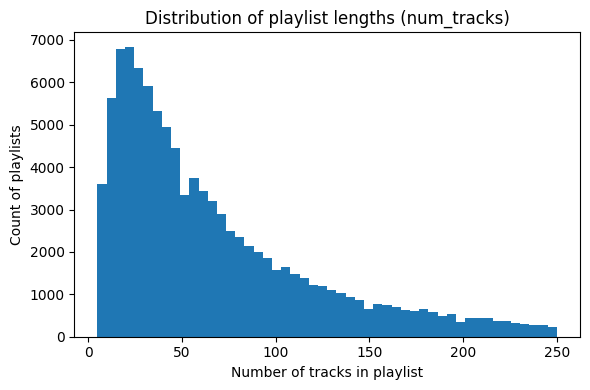

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(playlists_df["num_tracks"], bins=50)
plt.xlabel("Number of tracks in playlist")
plt.ylabel("Count of playlists")
plt.title("Distribution of playlist lengths (num_tracks)")
plt.tight_layout()
plt.show()


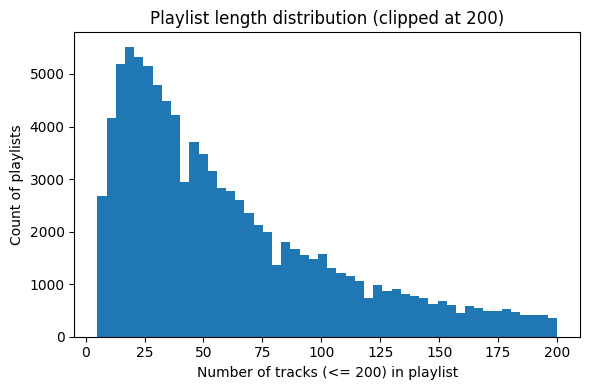

In [15]:
plt.figure(figsize=(6, 4))
subset = playlists_df[playlists_df["num_tracks"] <= 200]["num_tracks"]
plt.hist(subset, bins=50)
plt.xlabel("Number of tracks (<= 200) in playlist")
plt.ylabel("Count of playlists")
plt.title("Playlist length distribution (clipped at 200)")
plt.tight_layout()
plt.show()


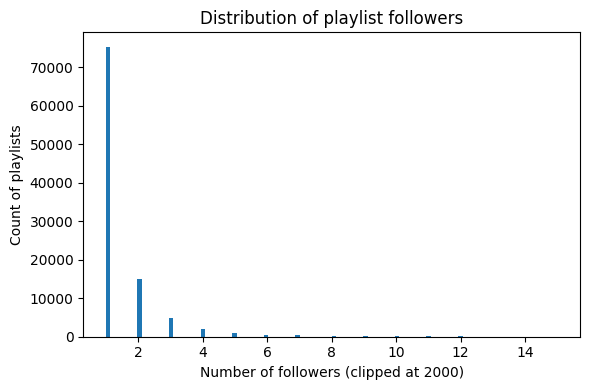

In [19]:
plt.figure(figsize=(6, 4))
subset = playlists_df["num_followers"]
subset = subset[subset <= 15]  # clip extreme outliers for visibility
plt.hist(subset, bins=100)
plt.xlabel("Number of followers (clipped at 2000)")
plt.ylabel("Count of playlists")
plt.title("Distribution of playlist followers")
plt.tight_layout()
plt.show()


In [20]:
import json
from pathlib import Path

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We assume these are already defined earlier in the notebook:
# PROJECT_ROOT, DATA_RAW, MPD_DIR, mpd_files

playlist_rows = []

for path in tqdm(mpd_files, desc="Building playlist-level table"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    playlists = data.get("playlists", [])
    
    for pl in playlists:
        playlist_rows.append({
            "pid": pl.get("pid"),
            "name": pl.get("name"),
            "num_tracks": pl.get("num_tracks"),
            "num_albums": pl.get("num_albums"),
            "num_followers": pl.get("num_followers"),
            "collaborative": pl.get("collaborative"),
            "modified_at": pl.get("modified_at"),
        })

playlists_df = pd.DataFrame(playlist_rows)
print("playlists_df shape:", playlists_df.shape)
playlists_df.head()


Building playlist-level table: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


playlists_df shape: (100000, 7)


,pid,name,num_tracks,num_albums,num_followers,collaborative,modified_at
0,0,Throwbacks,52,47,1,false,1493424000
1,1,Awesome Playlist,39,23,1,false,1506556800
2,2,korean,64,51,1,false,1505692800
3,3,mat,126,107,1,false,1501027200
4,4,90s,17,16,2,false,1401667200


In [21]:
print("=== Playlist-level numeric summary ===")
display(
    playlists_df[["num_tracks", "num_albums", "num_followers"]]
    .describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
    .T
)

print("\nCollaborative flag value counts:")
display(playlists_df["collaborative"].value_counts(dropna=False))


=== Playlist-level numeric summary ===


,count,mean,std,min,1%,5%,50%,95%,99%,max
num_tracks,100000.0,66.85101,53.913984,5.0,6.0,11.0,50.0,185.0,232.0,250.0
num_albums,100000.0,49.82734,40.004120,2.0,5.0,8.0,38.0,135.0,180.0,243.0
num_followers,100000.0,2.76475,132.259052,1.0,1.0,1.0,1.0,3.0,8.0,31539.0



Collaborative flag value counts:


collaborative
false    97761
true      2239
Name: count, dtype: int64

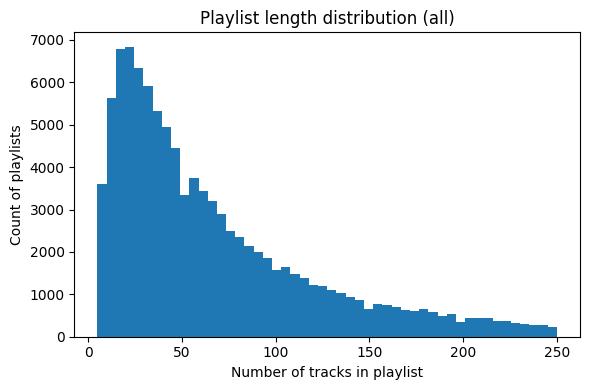

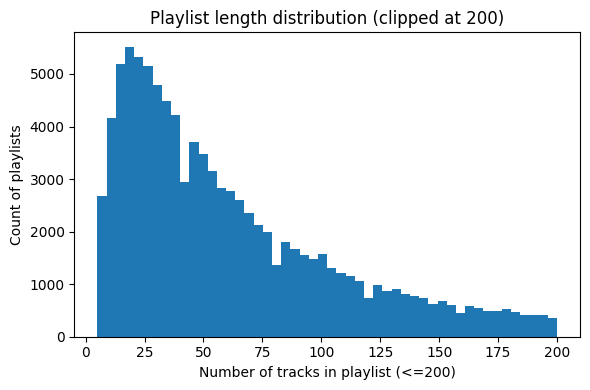

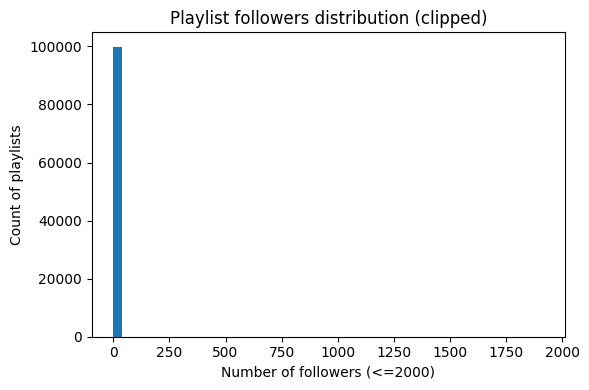

In [22]:
# Playlist length distribution
plt.figure(figsize=(6, 4))
plt.hist(playlists_df["num_tracks"], bins=50)
plt.xlabel("Number of tracks in playlist")
plt.ylabel("Count of playlists")
plt.title("Playlist length distribution (all)")
plt.tight_layout()
plt.show()

# Clipped version (for visibility)
plt.figure(figsize=(6, 4))
subset = playlists_df[playlists_df["num_tracks"] <= 200]["num_tracks"]
plt.hist(subset, bins=50)
plt.xlabel("Number of tracks in playlist (<=200)")
plt.ylabel("Count of playlists")
plt.title("Playlist length distribution (clipped at 200)")
plt.tight_layout()
plt.show()

# Followers distribution (clipped at 2000 for readability)
plt.figure(figsize=(6, 4))
followers = playlists_df["num_followers"]
followers = followers[followers <= 2000]
plt.hist(followers, bins=50)
plt.xlabel("Number of followers (<=2000)")
plt.ylabel("Count of playlists")
plt.title("Playlist followers distribution (clipped)")
plt.tight_layout()
plt.show()


Modified_at datetime range:
2011-03-09 00:00:00 → 2017-11-01 00:00:00


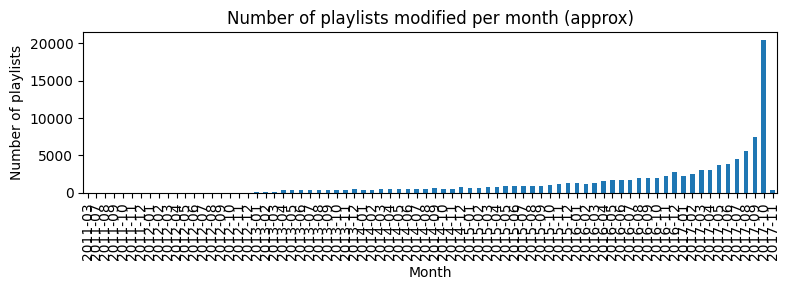

In [23]:
# modified_at is a Unix timestamp (seconds since epoch)
playlists_df["modified_at_dt"] = pd.to_datetime(
    playlists_df["modified_at"], unit="s", origin="unix"
)

print("Modified_at datetime range:")
print(playlists_df["modified_at_dt"].min(), "→", playlists_df["modified_at_dt"].max())

plt.figure(figsize=(8, 3))
playlists_df["modified_at_dt"].dt.to_period("M").value_counts().sort_index().plot(kind="bar")
plt.title("Number of playlists modified per month (approx)")
plt.xlabel("Month")
plt.ylabel("Number of playlists")
plt.tight_layout()
plt.show()


In [24]:
track_rows = []

for path in tqdm(mpd_files, desc="Building track-level table"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    playlists = data.get("playlists", [])
    
    for pl in playlists:
        pid = pl.get("pid")
        tracks = pl.get("tracks", [])
        for t in tracks:
            track_rows.append({
                "pid": pid,
                "track_uri": t.get("track_uri"),
                "artist_uri": t.get("artist_uri"),
                "album_uri": t.get("album_uri"),
                "track_name": t.get("track_name"),
                "artist_name": t.get("artist_name"),
                "album_name": t.get("album_name"),
                "pos": t.get("pos"),
                "duration_ms": t.get("duration_ms"),
            })

tracks_df = pd.DataFrame(track_rows)
print("tracks_df shape:", tracks_df.shape)
tracks_df.head()


Building track-level table: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


tracks_df shape: (6685101, 9)


,pid,track_uri,artist_uri,album_uri,track_name,artist_name,album_name,pos,duration_ms
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,0,226863
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,Toxic,Britney Spears,In The Zone,1,198800
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Crazy In Love,Beyoncé,Dangerously In Love (Alben für die Ewigkeit),2,235933
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Rock Your Body,Justin Timberlake,Justified,3,267266
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,It Wasn't Me,Shaggy,Hot Shot,4,227600


In [25]:
print("=== tracks_df basic info ===")
print("Rows (playlist-track interactions):", len(tracks_df))
print("Unique playlists (pid):", tracks_df["pid"].nunique())
print("Unique track_uris:", tracks_df["track_uri"].nunique())
print("Unique artist_uris:", tracks_df["artist_uri"].nunique())

# Approx sparsity for future playlist–track matrix
n_playlists = tracks_df["pid"].nunique()
n_tracks = tracks_df["track_uri"].nunique()
n_interactions = len(tracks_df)

density = n_interactions / (n_playlists * n_tracks)
print(f"\nPlaylist–track matrix dims: {n_playlists:,} x {n_tracks:,}")
print(f"Interactions: {n_interactions:,}")
print(f"Sparsity (density): {density:.6f}  (~{density*100:.4f}% non-zero)")


=== tracks_df basic info ===
Rows (playlist-track interactions): 6685101
Unique playlists (pid): 100000
Unique track_uris: 679889
Unique artist_uris: 109043

Playlist–track matrix dims: 100,000 x 679,889
Interactions: 6,685,101
Sparsity (density): 0.000098  (~0.0098% non-zero)


=== Tracks per playlist (from tracks_df) ===


count    100000.000000
mean         66.851010
std          53.913984
min           5.000000
1%            6.000000
5%           11.000000
50%          50.000000
95%         185.000000
99%         232.000000
max         250.000000
Name: track_uri, dtype: float64

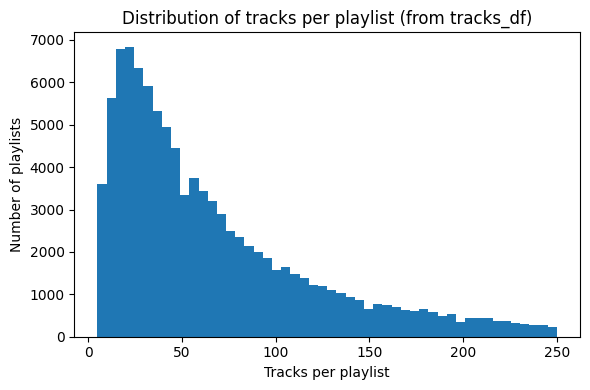

In [26]:
tracks_per_playlist = tracks_df.groupby("pid")["track_uri"].count()

print("=== Tracks per playlist (from tracks_df) ===")
display(tracks_per_playlist.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

plt.figure(figsize=(6, 4))
plt.hist(tracks_per_playlist, bins=50)
plt.xlabel("Tracks per playlist")
plt.ylabel("Number of playlists")
plt.title("Distribution of tracks per playlist (from tracks_df)")
plt.tight_layout()
plt.show()


=== Track frequency summary (count of playlists each track appears in) ===


count    679889.000000
mean          9.832636
std          66.026054
min           1.000000
50%           1.000000
90%          11.000000
99%         160.000000
max        4562.000000
Name: count, dtype: float64


Top 20 most common tracks:


,track_uri,count_in_playlists
0,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,4562
1,spotify:track:1xznGGDReH1oQq0xzbwXa3,4355
2,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,4105
3,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,4015
4,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,3985
5,spotify:track:5hTpBe8h35rJ67eAWHQsJx,3540
6,spotify:track:152lZdxL1OR0ZMW6KquMif,3485
7,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,3480
8,spotify:track:2EEeOnHehOozLq4aS0n6SL,3473
9,spotify:track:7GX5flRQZVHRAGd6B4TmDO,3456


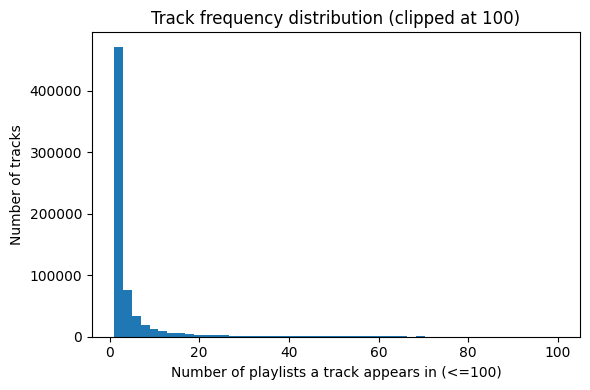

In [27]:
track_freq = tracks_df["track_uri"].value_counts()

print("=== Track frequency summary (count of playlists each track appears in) ===")
display(track_freq.describe(percentiles=[0.5, 0.9, 0.99]))

print("\nTop 20 most common tracks:")
top_tracks = track_freq.head(20).reset_index()
top_tracks.columns = ["track_uri", "count_in_playlists"]
display(top_tracks)

# Histogram of track frequencies (clipped)
plt.figure(figsize=(6, 4))
clipped = track_freq[track_freq <= 100]
plt.hist(clipped, bins=50)
plt.xlabel("Number of playlists a track appears in (<=100)")
plt.ylabel("Number of tracks")
plt.title("Track frequency distribution (clipped at 100)")
plt.tight_layout()
plt.show()


In [28]:
artist_freq = tracks_df["artist_uri"].value_counts()

print("=== Artist frequency summary (playlist appearances) ===")
display(artist_freq.describe(percentiles=[0.5, 0.9, 0.99]))

print("\nTop 20 most common artists:")
top_artists = artist_freq.head(20).reset_index()
top_artists.columns = ["artist_uri", "count_in_playlists"]
display(top_artists)

# Tracks per artist (unique tracks per artist)
tracks_per_artist = (
    tracks_df.groupby("artist_uri")["track_uri"]
    .nunique()
    .sort_values(ascending=False)
)

print("\n=== Unique tracks per artist ===")
display(tracks_per_artist.describe(percentiles=[0.5, 0.9, 0.99]))

print("\nTop 20 artists by number of unique tracks:")
display(tracks_per_artist.head(20))


=== Artist frequency summary (playlist appearances) ===


count    109043.000000
mean         61.307016
std         636.949774
min           1.000000
50%           2.000000
90%          39.000000
99%        1095.000000
max       85749.000000
Name: count, dtype: float64


Top 20 most common artists:


,artist_uri,count_in_playlists
0,spotify:artist:3TVXtAsR1Inumwj472S9r4,85749
1,spotify:artist:5K4W6rqBFWDnAN6FQUkS6x,42109
2,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,34420
3,spotify:artist:5pKCCKE2ajJHZ9KAiaK11H,33330
4,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,31199
5,spotify:artist:7dGJo4pcD2V6oG8kP0tJRR,30087
6,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,27154
7,spotify:artist:1RyvyyTE3xzB2ZywiAwp0i,25654
8,spotify:artist:6l3HvQ5sa6mXTsMTB19rO5,24684
9,spotify:artist:1uNFoZAHBGtllmzznpCI3s,23970



=== Unique tracks per artist ===


count    109043.000000
mean          6.235054
std          17.951952
min           1.000000
50%           2.000000
90%          13.000000
99%          75.000000
max         895.000000
Name: track_uri, dtype: float64


Top 20 artists by number of unique tracks:


artist_uri
spotify:artist:6MERXsiRbur2oJZFgYRDKz    895
spotify:artist:5aIqB5nVVvmFsvSdExz408    874
spotify:artist:2wOqMjp9TyABvtHdOSOTUS    822
spotify:artist:7y97mc3bZRFXzT2szRM4L4    763
spotify:artist:1Mxqyy3pSjf8kZZL4QVxS0    742
spotify:artist:4NJhFmfw43RLBLjQvxDuRS    714
spotify:artist:0SCbttzoZTnLFebDYmAWCm    602
spotify:artist:3MKCzCnpzw3TjUYs2v7vDA    588
spotify:artist:3dRfiJ2650SZu6GbydcHNb    574
spotify:artist:4TMHGUX5WI7OOm53PqSDAT    571
spotify:artist:6kACVPfCOnqzgfEF5ryl0x    548
spotify:artist:13y7CgLHjMVRMDqxdx0Xdo    528
spotify:artist:0YC192cP3KPCRWx8zr8MfZ    504
spotify:artist:1Vvvx45Apu6dQqwuZQxtgW    486
spotify:artist:2QsynagSdAqZj3U9HgDzjD    479
spotify:artist:0LyfQWJT6nXafLPZqxe9Of    474
spotify:artist:74ASZWbe4lXaubB36ztrGX    445
spotify:artist:5V0MlUE1Bft0mbLlND7FJz    439
spotify:artist:43ZHCT0cAZBISjO8DG9PnE    402
spotify:artist:22bE4uQ6baNwSHPVcDxLCe    398
Name: track_uri, dtype: int64

=== Playlist diversity summary ===


,count,mean,std,min,1%,5%,50%,95%,99%,max
unique_tracks,100000.0,65.958950,52.942240,3.000000,6.000000,11.000000,49.000000,182.000000,228.0,250.0
unique_artists,100000.0,38.118860,30.171035,3.000000,3.000000,6.000000,30.000000,100.000000,141.0,224.0
num_tracks,100000.0,66.851010,53.913984,5.000000,6.000000,11.000000,50.000000,185.000000,232.0,250.0
artist_per_track_ratio,100000.0,0.640158,0.226603,0.012245,0.069182,0.209606,0.666667,0.981132,1.0,1.0


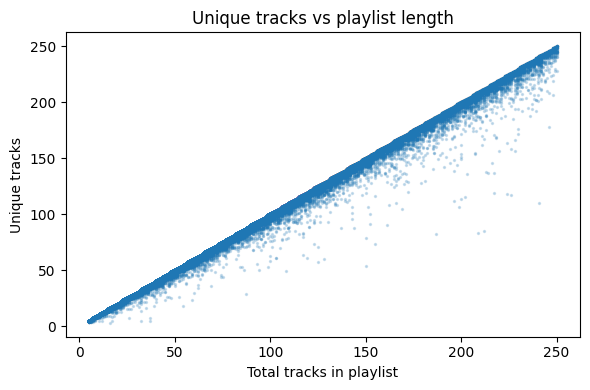

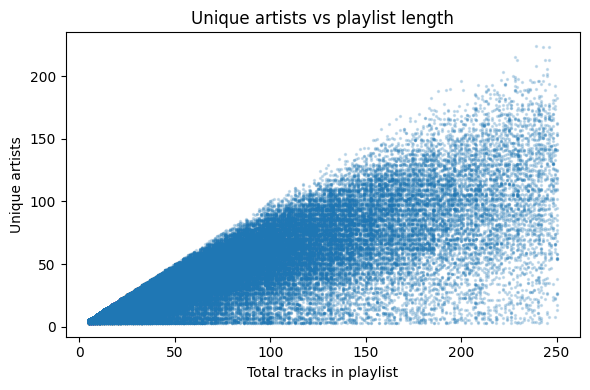

In [29]:
# Unique tracks per playlist
uniq_tracks_per_pl = tracks_df.groupby("pid")["track_uri"].nunique()
# Unique artists per playlist
uniq_artists_per_pl = tracks_df.groupby("pid")["artist_uri"].nunique()

diversity_df = pd.DataFrame({
    "unique_tracks": uniq_tracks_per_pl,
    "unique_artists": uniq_artists_per_pl,
    "num_tracks": tracks_per_playlist,  # from earlier cell
})
diversity_df["artist_per_track_ratio"] = (
    diversity_df["unique_artists"] / diversity_df["num_tracks"]
)

print("=== Playlist diversity summary ===")
display(diversity_df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)

# Plot unique tracks vs playlist length
plt.figure(figsize=(6, 4))
plt.scatter(diversity_df["num_tracks"], diversity_df["unique_tracks"], s=2, alpha=0.2)
plt.xlabel("Total tracks in playlist")
plt.ylabel("Unique tracks")
plt.title("Unique tracks vs playlist length")
plt.tight_layout()
plt.show()

# Plot unique artists vs playlist length
plt.figure(figsize=(6, 4))
plt.scatter(diversity_df["num_tracks"], diversity_df["unique_artists"], s=2, alpha=0.2)
plt.xlabel("Total tracks in playlist")
plt.ylabel("Unique artists")
plt.title("Unique artists vs playlist length")
plt.tight_layout()
plt.show()


In [30]:
def show_random_playlists(n=3, seed=42):
    rng = np.random.default_rng(seed)
    sample_pids = rng.choice(playlists_df["pid"].unique(), size=n, replace=False)
    print(f"Random sample of {n} playlists (pids): {sample_pids}\n")
    
    for pid in sample_pids:
        pl_meta = playlists_df[playlists_df["pid"] == pid].iloc[0]
        pl_tracks = tracks_df[tracks_df["pid"] == pid].sort_values("pos")
        
        print(f"PID: {pid}")
        print(f"Name: {pl_meta['name']}")
        print(f"Num tracks: {pl_meta['num_tracks']}")
        print(f"Num followers: {pl_meta['num_followers']}")
        print("First 5 tracks:")
        for _, row in pl_tracks.head(5).iterrows():
            print("  -", row["track_name"], "–", row["artist_name"])
        print("-" * 60)

show_random_playlists(n=3, seed=123)


Random sample of 3 playlists (pids): [151294  16234   1544]

PID: 151294
Name: run!!!
Num tracks: 52
Num followers: 1
First 5 tracks:
  - Love On Me – Galantis
  - Spice Up Your Life – Spice Girls
  - Kiss This – The Struts
  - Let’s Go – Matt and Kim
  - Let Go – RAC
------------------------------------------------------------
PID: 16234
Name: New Music
Num tracks: 25
Num followers: 1
First 5 tracks:
  - Vowels – Capital Cities
  - HUMBLE. – Kendrick Lamar
  - Shape of You – Ed Sheeran
  - That's What I Like – Bruno Mars
  - Galway Girl – Ed Sheeran
------------------------------------------------------------
PID: 1544
Name: vibe
Num tracks: 40
Num followers: 6
First 5 tracks:
  - Drowsy – Banes World
  - Running – Nicotine's Famous Honey
  - Night Drive – Ari Lennox
  - Dark Red – Steve Lacy
  - 911 / Mr. Lonely – Tyler, The Creator
------------------------------------------------------------


In [31]:
# Count how many playlists each track appears in
track_counts = (
    tracks_df.groupby(["track_uri", "track_name"])
             .size()
             .reset_index(name="count")
             .sort_values("count", ascending=False)
)

print("Top 20 Most Common Tracks Across Playlists:")
display(track_counts.head(20))


Top 20 Most Common Tracks Across Playlists:


,track_uri,track_name,count
639622,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,HUMBLE.,4562
172235,spotify:track:1xznGGDReH1oQq0xzbwXa3,One Dance,4355
678433,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,Broccoli (feat. Lil Yachty),4105
626735,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,Closer,4015
312437,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,Congratulations,3985
497414,spotify:track:5hTpBe8h35rJ67eAWHQsJx,Caroline,3540
94678,spotify:track:152lZdxL1OR0ZMW6KquMif,Location,3485
378524,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,Bad and Boujee (feat. Lil Uzi Vert),3480
194994,spotify:track:2EEeOnHehOozLq4aS0n6SL,iSpy (feat. Lil Yachty),3473
634022,spotify:track:7GX5flRQZVHRAGd6B4TmDO,XO TOUR Llif3,3456


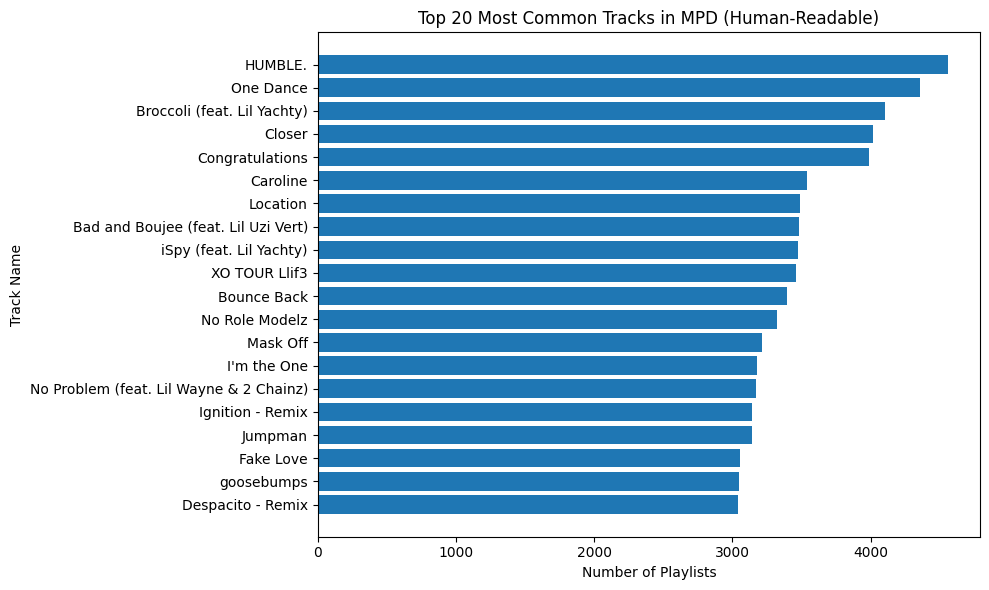

In [32]:
top_tracks = track_counts.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_tracks["track_name"].iloc[::-1], top_tracks["count"].iloc[::-1])
plt.xlabel("Number of Playlists")
plt.ylabel("Track Name")
plt.title("Top 20 Most Common Tracks in MPD (Human-Readable)")
plt.tight_layout()
plt.show()


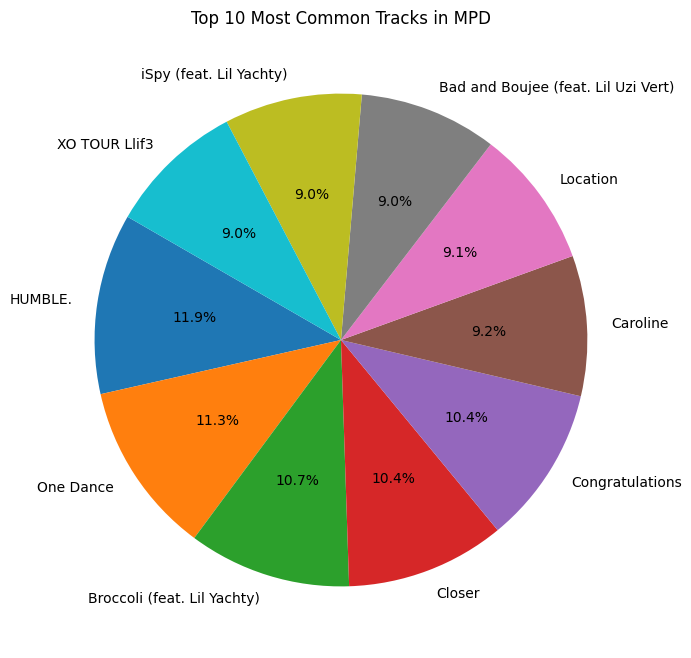

In [33]:
top10 = track_counts.head(10)

plt.figure(figsize=(8, 8))
plt.pie(
    top10["count"],
    labels=top10["track_name"],
    autopct="%1.1f%%",
    startangle=150
)
plt.title("Top 10 Most Common Tracks in MPD")
plt.show()


In [34]:
artist_counts = (
    tracks_df.groupby(["artist_uri", "artist_name"])
             .size()
             .reset_index(name="count")
             .sort_values("count", ascending=False)
)

print("Top 20 Most Common Artists:")
display(artist_counts.head(20))


Top 20 Most Common Artists:


,artist_uri,artist_name,count
48646,spotify:artist:3TVXtAsR1Inumwj472S9r4,Drake,85749
74420,spotify:artist:5K4W6rqBFWDnAN6FQUkS6x,Kanye West,42109
35802,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,34420
81397,spotify:artist:5pKCCKE2ajJHZ9KAiaK11H,Rihanna,33330
21624,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,31199
103773,spotify:artist:7dGJo4pcD2V6oG8kP0tJRR,Eminem,30087
92862,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,27154
20264,spotify:artist:1RyvyyTE3xzB2ZywiAwp0i,Future,25654
94440,spotify:artist:6l3HvQ5sa6mXTsMTB19rO5,J. Cole,24684
26708,spotify:artist:1uNFoZAHBGtllmzznpCI3s,Justin Bieber,23970


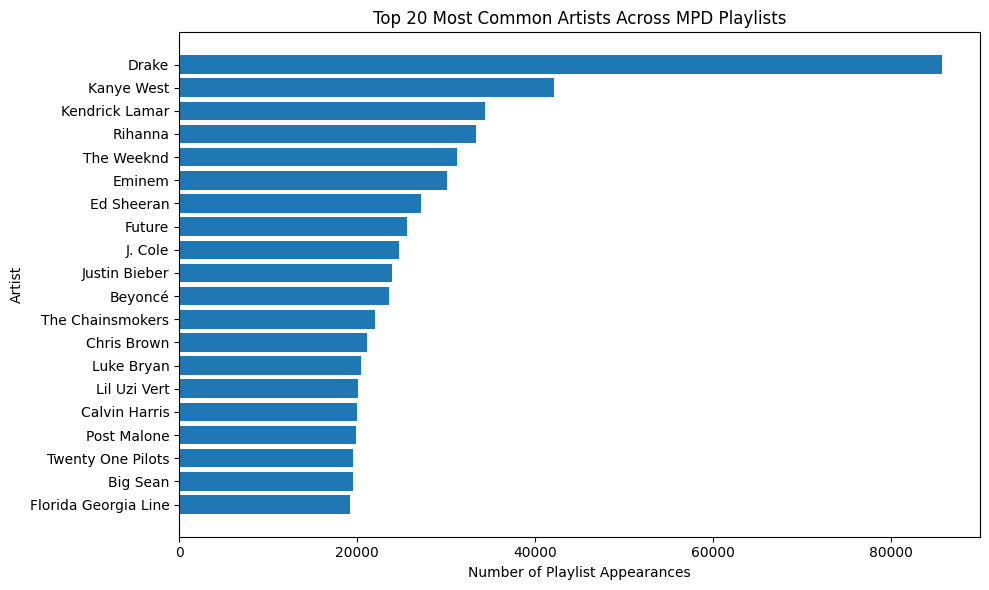

In [35]:
top_artists = artist_counts.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_artists["artist_name"].iloc[::-1], top_artists["count"].iloc[::-1])
plt.xlabel("Number of Playlist Appearances")
plt.ylabel("Artist")
plt.title("Top 20 Most Common Artists Across MPD Playlists")
plt.tight_layout()
plt.show()


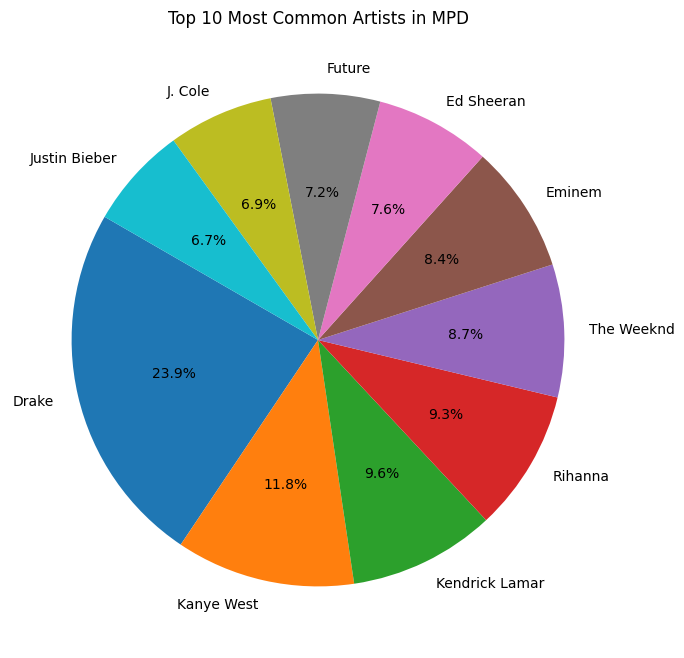

In [36]:
top10_artists = artist_counts.head(10)

plt.figure(figsize=(8, 8))
plt.pie(
    top10_artists["count"],
    labels=top10_artists["artist_name"],
    autopct="%1.1f%%",
    startangle=150
)
plt.title("Top 10 Most Common Artists in MPD")
plt.show()


In [37]:
album_counts = (
    tracks_df.groupby(["album_uri", "album_name"])
             .size()
             .reset_index(name="count")
             .sort_values("count", ascending=False)
)

print("Top 20 Most Common Albums:")
display(album_counts.head(20))


Top 20 Most Common Albums:


,album_uri,album_name,count
203909,spotify:album:5s0rmjP8XOPhP6HhqOhuyC,Stoney,15970
161522,spotify:album:4eLPsYPBmXABThSJ821sqY,DAMN.,13814
243550,spotify:album:71QyofYesSsRMwFOTafnhB,Coloring Book,13556
234236,spotify:album:6kf46HbnYCZzP6rjvQHYzg,American Teen,12056
75819,spotify:album:2AvupjUeMnSffKEV05x222,Culture,11966
61700,spotify:album:1lXY618HWkwYKJWBRYR4MK,More Life,11830
258891,spotify:album:7fZH0aUAjY3ay25obOUf2a,Purpose,11627
128665,spotify:album:3hARKC8cinq3mZLLAEaBh9,Views,11485
259645,spotify:album:7gsWAHLeT0w7es6FofOXk1,The Life Of Pablo,11403
74531,spotify:album:28ZKQMoNBB0etKXZ97G2SN,Beauty Behind The Madness,11240


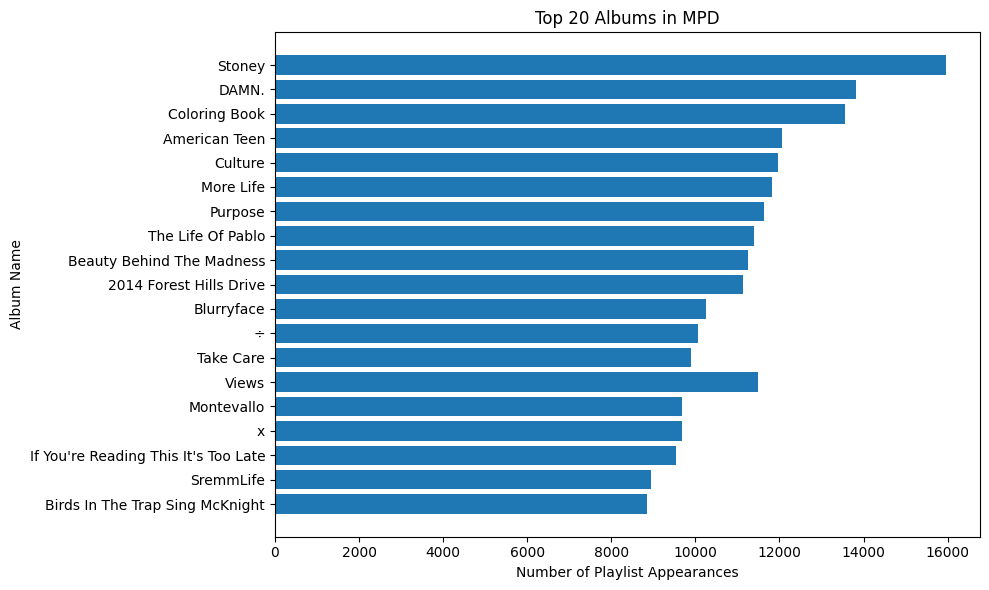

In [38]:
top_albums = album_counts.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_albums["album_name"].iloc[::-1], top_albums["count"].iloc[::-1])
plt.xlabel("Number of Playlist Appearances")
plt.ylabel("Album Name")
plt.title("Top 20 Albums in MPD")
plt.tight_layout()
plt.show()


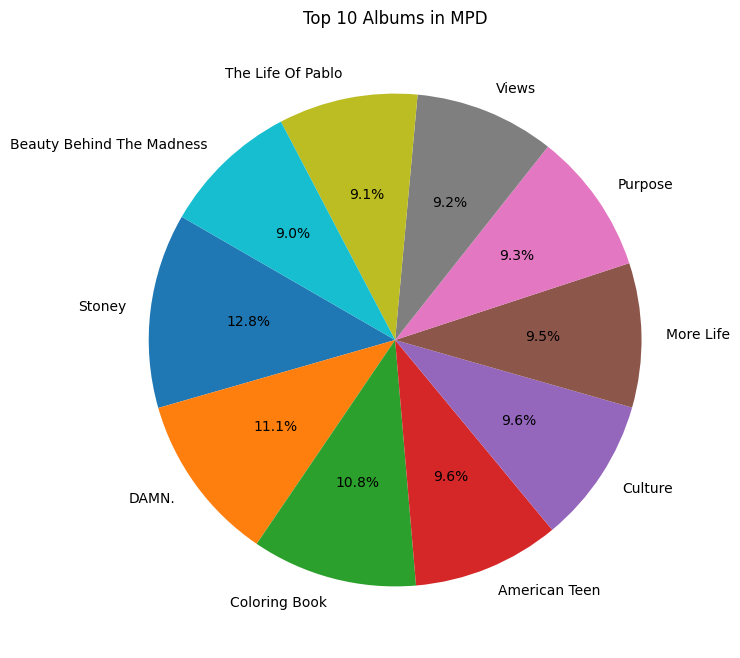

In [39]:
top10_albums = album_counts.head(10)

plt.figure(figsize=(8, 8))
plt.pie(
    top10_albums["count"],
    labels=top10_albums["album_name"],
    autopct="%1.1f%%",
    startangle=150
)
plt.title("Top 10 Albums in MPD")
plt.show()


In [40]:
summary = {
    "Top Tracks": track_counts.head(10)[["track_name", "count"]],
    "Top Artists": artist_counts.head(10)[["artist_name", "count"]],
    "Top Albums": album_counts.head(10)[["album_name", "count"]],
}

for section, df in summary.items():
    print(f"\n=== {section} ===")
    display(df)



=== Top Tracks ===


,track_name,count
639622,HUMBLE.,4562
172235,One Dance,4355
678433,Broccoli (feat. Lil Yachty),4105
626735,Closer,4015
312437,Congratulations,3985
497414,Caroline,3540
94678,Location,3485
378524,Bad and Boujee (feat. Lil Uzi Vert),3480
194994,iSpy (feat. Lil Yachty),3473
634022,XO TOUR Llif3,3456



=== Top Artists ===


,artist_name,count
48646,Drake,85749
74420,Kanye West,42109
35802,Kendrick Lamar,34420
81397,Rihanna,33330
21624,The Weeknd,31199
103773,Eminem,30087
92862,Ed Sheeran,27154
20264,Future,25654
94440,J. Cole,24684
26708,Justin Bieber,23970



=== Top Albums ===


,album_name,count
203909,Stoney,15970
161522,DAMN.,13814
243550,Coloring Book,13556
234236,American Teen,12056
75819,Culture,11966
61700,More Life,11830
258891,Purpose,11627
128665,Views,11485
259645,The Life Of Pablo,11403
74531,Beauty Behind The Madness,11240
